# CP-SAT CVRPTW Optimization
**C**apacitated **V**ehicle **R**outing **P**roblem with **T**ime **W**indows

A comprehensive implementation of the Capacitated Vehicle Routing Problem with Time Windows using Google **OR-Tools CP-SAT** solver, applied to delivery optimization in the São Paulo metropolitan area.

## Problem overview
This project *simulates* a real-world logistics optimization problem where multiple trucks with different capacities and operating costs need to deliver goods to various locations within specific time windows while minimizing total transportation costs *(optional)*.

### Problem features
- **Multi-vehicle fleet** with different capacities, speeds, and operating costs.
- **Time window constraints** for delivery scheduling (Monday-Friday).
- **Capacity constraints** for each vehicle.
- **Distance-based routing** calculating the total distance in km using haversine.
- **Cost optimization** considering transportation costs.
- **Working hour limits** and maximum tours per day constraints.

### The dataset
The simulation uses realistic data centered around *São Paulo, Brazil*:
- **20 delivery locations** across São Paulo metropolitan area *(actual geographical coordinates)*.
- **5 different trucks** with varying travel speeds, capacities and delivery fees.
- **5-day delivery window** from Monday to Friday.
- **Distances** ranging from 50-100 km away from the depot.

### Constraints implemented
- **Multiple circuiting**: Ensure valid tours and allows multiple tours per day.
- **Flow conservation**: Maintains the route continuity for each truck - *If a truck delivers at n it must leave n*.
- **Capacity constraint**: Respect each truck's capacity limit.
- **Time window constraints**: Make the delivery within the specified days.
- **Work hour limits**: Maximum 8 hours per truck per day.
- **Tour limits**: Maximum 2 tours per truck per day.

## Problem code

### Imports

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Main optimization library
from ortools.sat.python import cp_model

# Build graphs
import networkx as nx

# Calculate the distance in km
from sklearn.metrics.pairwise import haversine_distances

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Other
import itertools
from datetime import timedelta
from copy import deepcopy

### Orders data

In [2]:
orders = pd.DataFrame([
    {"order_id": 0, "latitude": -23.55052, "longitude": -46.633308, "due_date": "Monday", "demand": 0}, # depot (São Paulo center)
    {"order_id": 1, "latitude": -23.2237, "longitude": -46.0123, "due_date": "Monday", "demand": 10},    # São José dos Campos (~95 km)
    {"order_id": 2, "latitude": -23.9638, "longitude": -45.9823, "due_date": "Monday", "demand": 15},    # Santos (~72 km)
    {"order_id": 3, "latitude": -23.1939, "longitude": -46.8919, "due_date": "Tuesday", "demand": 8},    # Jundiaí (~60 km)
    {"order_id": 4, "latitude": -22.9056, "longitude": -47.0608, "due_date": "Tuesday", "demand": 12},   # Campinas (~95 km)
    {"order_id": 5, "latitude": -23.6821, "longitude": -47.1321, "due_date": "Wednesday", "demand": 7},  # Sorocaba (~65 km)
    {"order_id": 6, "latitude": -23.3292, "longitude": -45.8348, "due_date": "Wednesday", "demand": 14}, # Taubaté (~85 km)
    {"order_id": 7, "latitude": -24.0183, "longitude": -46.4095, "due_date": "Thursday", "demand": 10},  # Praia Grande (~80 km)
    {"order_id": 8, "latitude": -23.5125, "longitude": -45.4053, "due_date": "Thursday", "demand": 9},   # Jacareí (~88 km)
    {"order_id": 9, "latitude": -22.7309, "longitude": -47.6403, "due_date": "Friday", "demand": 13},    # Piracicaba (~100 km)
    {"order_id": 10, "latitude": -23.7950, "longitude": -45.8643, "due_date": "Friday", "demand": 16},   # São Sebastião (~95 km)
    {"order_id": 11, "latitude": -23.5268, "longitude": -47.4658, "due_date": "Monday", "demand": 11},   # Itu (~80 km)
    {"order_id": 12, "latitude": -23.0965, "longitude": -47.2208, "due_date": "Monday", "demand": 6},    # Salto (~75 km)
    {"order_id": 13, "latitude": -24.2843, "longitude": -47.0016, "due_date": "Tuesday", "demand": 14},  # Registro (~85 km)
    {"order_id": 14, "latitude": -22.8188, "longitude": -46.5647, "due_date": "Tuesday", "demand": 9},   # Bragança Paulista (~85 km)
    {"order_id": 15, "latitude": -23.4196, "longitude": -45.0778, "due_date": "Wednesday", "demand": 10}, # Caraguatatuba (~95 km)
    {"order_id": 16, "latitude": -24.0126, "longitude": -46.9536, "due_date": "Wednesday", "demand": 7},  # Itanhaém (~70 km)
    {"order_id": 17, "latitude": -22.5504, "longitude": -47.4009, "due_date": "Thursday", "demand": 12},  # Americana (~100 km)
    {"order_id": 18, "latitude": -22.8934, "longitude": -45.8050, "due_date": "Thursday", "demand": 11},  # Campos do Jordão (~90 km)
    {"order_id": 19, "latitude": -22.4154, "longitude": -46.9034, "due_date": "Friday", "demand": 13},    # Atibaia (~70 km)
    {"order_id": 20, "latitude": -23.9537, "longitude": -47.3074, "due_date": "Friday", "demand": 15},    # Piedade (~80 km)
]).drop(columns="order_id")

# Encoding the due_date
day_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4
}

# Apply the mapping
orders["due_date"] = orders["due_date"].map(day_map).astype(int)

# Coordinates
orders["coord"] = orders.apply(lambda s: tuple(s[["latitude", "longitude"]]), axis=1)

# Display the result
orders.head()

,latitude,longitude,due_date,demand,coord
0,-23.55052,-46.633308,0,0,"(-23.55052, -46.633308)"
1,-23.22370,-46.012300,0,10,"(-23.2237, -46.0123)"
2,-23.96380,-45.982300,0,15,"(-23.9638, -45.9823)"
3,-23.19390,-46.891900,1,8,"(-23.1939, -46.8919)"
4,-22.90560,-47.060800,1,12,"(-22.9056, -47.0608)"


### Available trucks

In [3]:
trucks = pd.DataFrame([
    {"truck_id": 1, "capacity": 40, "cost_per_km": 1.1, "avg_speed": 35},
    {"truck_id": 2, "capacity": 35, "cost_per_km": 0.95, "avg_speed": 38},
    {"truck_id": 3, "capacity": 50, "cost_per_km": 1.05, "avg_speed": 45},
    {"truck_id": 4, "capacity": 30, "cost_per_km": 0.95, "avg_speed": 40},
    {"truck_id": 5, "capacity": 45, "cost_per_km": 1.0, "avg_speed": 37},
]).drop(columns="truck_id")
trucks.head()

,capacity,cost_per_km,avg_speed
0,40,1.10,35
1,35,0.95,38
2,50,1.05,45
3,30,0.95,40
4,45,1.00,37


### Problem setup

#### Graph to represent the deliveries

In [4]:
# Create a graph to represent the orders
G = nx.complete_graph(len(orders)) # + depot

# Add the node information
for o, order in orders.iterrows():
    G.nodes[o].update(order.to_dict())

# Calculate the distances and costs of the edges
for u in G.nodes:
    for v in G.nodes:
        if u != v:
            # Create the coordinates in radians
            coord_u = np.radians(G.nodes[u]["coord"]).reshape((1, -1))
            coord_v = np.radians(G.nodes[v]["coord"]).reshape((1, -1))
            distance = 6371.0 * haversine_distances(coord_u, coord_v).item()

            # Initialize the edge data
            edge_data = {
                "distance": distance,
            }

            # Travel time and cost per truck

            # Time to load the truck (+ 1 hour)
            loading_time = 1.0 if u == 0 else 0.0

            # Time to deliver the products
            delivery_time = 0.5 if v != 0 else 0.0
            
            for t, truck in trucks.iterrows():
                travel_time = distance / truck["avg_speed"]
                edge_data.update({
                    t: {
                        "truck": t,
                        "travel_time": travel_time,
                        "total_time": travel_time + loading_time + delivery_time,
                        "cost": round(distance * truck["cost_per_km"], 2)
                    }
                })

            # Add the edge data to the edge
            G[u][v].update(edge_data)

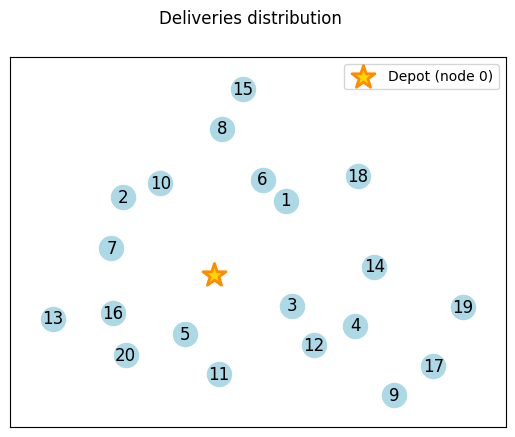

In [5]:
# Get the coordinates for each node {n0: coord0, n1: coord1, ...}
pos = nx.get_node_attributes(G, "coord")

fig, ax = plt.subplots()
fig.suptitle("Deliveries distribution")

# Draw the depot
ax.scatter(
    *G.nodes[0]["coord"],
    marker="*",
    s=300,
    color="gold",
    edgecolors="darkorange",
    linewidths=2,
    label="Depot (node 0)"
)


# Draw the orders' delivery locations
orders_graph = deepcopy(G)
orders_graph.remove_node(0)
nx.draw_networkx(orders_graph, 
                 pos,
                 node_color="lightblue",
                 width=0.0, # Exclude edges
                 ax=ax)
plt.legend()
plt.show()

### Optimization setup

#### CP-SAT instances

In [6]:
# CP-SAT instances
model = cp_model.CpModel()
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 30
solver.parameters.random_seed = 42

#### Main arc variables

We define the main **arc variables** to represent whether each arc (or edge) between nodes is used in the solution. Each arc is a binary (boolean) variable indicating if the truck travels directly from one node to another.

For example, in a problem with two customers, the graph consists of 3 nodes (one for each customer plus one for the *depot*) and 6 possible arcs. These arcs account for all possible trips the truck might take, such as leaving the depot for *node 1* and returning from *node 2* to the *depot*. The model must capture all permutations of the route, including cases like *depot → node 1 → node 2 → depot*. That’s why arcs like *u → v* and *v → u* need to be modeled as distinct possibilities.

Note: **arc** and **edge** are used interchangeably here.

In [7]:
arc_vars = {
    (u, v): model.new_bool_var(f"arc_{u}_{v}") 
    for (u, v) in itertools.permutations(G.nodes, 2) # Create permutations
}

# Constraint to visit all nodes by allowing multiple circuits
model.add_multiple_circuit([(u, v, var) for (u, v), var in arc_vars.items()]);

#### Trucks arc variables

Building on the **main arc variables**, we define the **truck-specific arc variables**. Each truck has its own set of arc variables, introducing an additional dimension **truck** $(t)$ to the model, alongside the **origin node** $(u)$ and **destination node** $(v)$.

However, because we are working with **time windows**, we also need to incorporate a **time dimension** $(d)$ into the truck arc variables. This allows the model to represent not just the assignment of trucks to arcs, but also the timing of each truck's traversal. In other words, the truck-specific arc variables answer the question: 
> *"Does truck $t$ traverse the arc from $u$ to $v$ on day $d$?"*

These variables ensure that the model accounts for capacity constraints, time window requirements, and route feasibility for each truck in the fleet.

In [8]:
truck_arc_vars = {
    (t, d, u, v): model.new_bool_var(f"{t}_{d}_{u}_{v}")
    for t in trucks.index
    for d in range(5) # Mon -> Fri
    for (u, v) in itertools.permutations(G.nodes, 2)
}

# Bind the main arc variables to each truck variable
for (u, v), var in arc_vars.items():
    # List all trucks arcs that go from u to v independent of the day
    arcs = [truck_var for k, truck_var in truck_arc_vars.items() if k[-2:] == (u, v)]

    # Add a conditional constraint to force the model to pick a truck
    # for the given arc if being used
    model.add(sum(arcs) == 1).only_enforce_if(var) # Can't use `add_exactly_one`

    # On arcs not being used no truck should be picked
    model.add(sum(arcs) == 0).only_enforce_if(var.Not())

#### Flow conservation

We need to ensure that for every truck $(t)$, each day $(d)$ and each node $(n)$ the total inflow must equal the total outflow. In other words, if a truck arrives at node $(n)$ on day $(d)$, it must also depart from that node on the same day. This ensures continuity in the route, preventing the truck from *"getting stuck"* at any node.

In [9]:
for t in trucks.index:
    for d in range(5):
        for n in G.nodes:
            # Flow entering the node (u -> n)
            inflow = [var for k, var in truck_arc_vars.items() if k[:2] == (t, d) and k[-1] == n]
            # Flow leaving the node (n -> v)
            outflow = [var for k, var in truck_arc_vars.items() if k[:2] == (t, d) and k[-2] == n]
            model.add(sum(inflow) == sum(outflow))

#### Capacity constraint

In [10]:
cap_vars = {
    (t, d, n): model.new_int_var(0, int(truck["capacity"]), f"{t}_{d}_{n}_capacity")
    for t, truck in trucks.iterrows()
    for d in range(5) # Mon -> Fri
    for n in G.nodes
}

# Calculate the capacity daily
for (t, d, u, v), var in truck_arc_vars.items():
    # Get the destination node demand
    demand = int(G.nodes[v]["demand"])
    # If leaving the depot at any moment the capacity starts at 0
    if u == 0:
        model.add(cap_vars[t, d, v] >= demand).only_enforce_if(var)
    else:
        # If the truck leaves from any other node to another node the capacity increases
        model.add(cap_vars[t, d, v] >= cap_vars[t, d, u] + demand).only_enforce_if(var)

#### Time Window constraint

In [11]:
for n, order in orders.iterrows():
    # Skip the depot
    if n == 0:
        continue
        
    # Get the order due day
    due_day = order["due_date"]

    # Ensure any arcs are going to the order's node on the
    # due day or any days before
    arcs = []
    for d in range(5):
        if d <= due_day:
            # List all arcs for all trucks going to n on that day
            arcs.extend([var for k, var in truck_arc_vars.items() if k[1] == d and k[-1] == n])  # (u -> n)

    # Finally, for that order, ensure a selected arc        
    model.add(sum(arcs) == 1)

#### Maximum amount of tours per day per truck

In [12]:
max_tours_per_day = 2

for t in trucks.index:
    for d in range(5):
        # Select all arcs that complete a tour - i.e. all ending on the depot
        n_tours = [var for k, var in truck_arc_vars.items() if k[:2] == (t, d) and k[-1] == 0]
        model.add(sum(n_tours) <= max_tours_per_day)

#### Maximum work hours

The `total_time` attribute for each truck's arc is a float value. Since [CP-SAT does not support floats](https://github.com/d-krupke/cpsat-primer#:~:text=CP%2DSAT%20works%20by%20converting%20all%20integer%20variables%20into%20boolean%20variables%20(warning%3A%20simplification).%20For%20each%20potential%20value%2C%20it%20creates%20two%20boolean%20variables%3A%20one%20indicating%20whether%20the%20integer%20variable%20is%20equal%20to%20this%20value%2C%20and%20another%20indicating%20whether%20it%20is%20less%20than%20or%20equal%20to%20it.), we can't directly use these values without modification. Simply casting the floats to integers would result in a loss of decimal precision, which could significantly impact the accuracy of the model.

To address this, we **scale up** the float values by a constant factor, preserving the decimal information in integer form. For example, multiplying by 100 converts `1.23` to `123`. After solving the problem in integer space, we **scale down** by dividing by the same factor to recover the original value: `123 / 100 = 1.23`.

Note: The larger the scaling factor, the less precision is lost, especially for floats with many decimal places. For example, `1.2345678 * 100 = 123`, which recovers `1.23` when scaled back down, while `1.2345678 * 10,000 = 12,346` recovers `1.2346` when scaled down—closer to the original.

In [13]:
max_work_hours = 8

for t in trucks.index:
    for d in range(5):
        # Sum the worked hours per day
        worked_hours = sum(var * int(1_000 * G[k[-2]][k[-1]][t]["total_time"]) for k, var in truck_arc_vars.items() if k[:2] == (t, d))
        model.add(worked_hours <= int(1_000 * max_work_hours))

#### (Optional) Objective: Minimize the overall cost of the deliveries

> *Not every problem necessitates an objective; sometimes, finding a feasible solution is sufficient.*

CP-SAT is a **Constraint Programming** solver designed to handle discrete optimization problems by enforcing logical and mathematical constraints over integer variables [[Ref]](https://github.com/d-krupke/cpsat-primer#:~:text=Not%20every%20problem,on%20my%20experience.). While it excels at finding feasible solutions that satisfy all constraints, it can also handle optimization objectives, such as minimizing delivery costs.

Note: When objectives are included, they may increase the solver's complexity and runtime. For instance, some times objectives require the creation of extra variables to handle logic calculations based on the main variables' values.

In [14]:
# Scale the individual costs and convert to integer
total_cost = sum(var * int(1_000 * G[u][v][t]["cost"]) for (t, d, u, v), var in truck_arc_vars.items())
model.minimize(total_cost)

In [15]:
class SolutionPrinter(cp_model.CpSolverSolutionCallback):
    """A simple solution printer

    This callback prints the desired expression which can be a
    standalone variable or an expression of variables.
    
    """
    def __init__(self, 
                 expr: cp_model.LinearExprT):
        super().__init__()
        self.expr = expr
        self.n_solutions = 0

    def on_solution_callback(self):
        """
        Prints the value when a solution is found
        """
        self.n_solutions += 1
        expr_value = self.value(self.expr)
        print(f"Solution {self.n_solutions}: {expr_value:,.0f}")

### Solving the model

In [16]:
import os


print(f"Count of CPUs: {os.cpu_count()}")

Count of CPUs: 12


In [17]:
%%time
solver.parameters.num_search_workers = os.cpu_count() # Increase the number of parallel searches
solution_printer = SolutionPrinter(total_cost)
solver.solve(model, solution_callback=solution_printer)
solver.status_name()

Solution 1: 2,844,190
Solution 2: 2,819,310
Solution 3: 2,787,450
Solution 4: 2,576,390
Solution 5: 2,570,710
Solution 6: 2,543,810
Solution 7: 2,432,810
Solution 8: 2,419,820
Solution 9: 2,379,740
Solution 10: 2,244,120
Solution 11: 2,207,290
Solution 12: 2,195,990
Solution 13: 2,183,290
Solution 14: 2,178,900
Solution 15: 2,175,840
Solution 16: 2,174,500
Solution 17: 1,997,110
Solution 18: 1,975,720
Solution 19: 1,938,080
Solution 20: 1,791,660
CPU times: user 5min 25s, sys: 1.11 s, total: 5min 26s
Wall time: 30.7 s


'FEASIBLE'

### Results

In [18]:
obj_value = solver.objective_value
print(f"Total cost of deliveries: {obj_value / 1_000:,.2f}") # Scale down

Total cost of deliveries: 1,791.66


In [19]:
# Create a graph for each day of the week
SG = [nx.DiGraph() for _ in range(5)]

# Add the edges given the solutions
for (t, d, u, v), var in truck_arc_vars.items():
    if solver.value(var):
        # Add the edge
        SG[d].add_edge(u, v, **G[u][v][t])

# Add the nodes coordinates
for g in SG:
    nodes = set([v for e in g.edges for v in e])
    for n in nodes:
        g.nodes[n].update(G.nodes[n])

In [20]:
def create_tour_graphs(g: nx.DiGraph, source=0) -> list[nx.DiGraph]:
    """
    Create individual directed graphs for each circuit
    """
    # Holds a list for each tour
    tours_list = []
    # Initial tour
    curr_tour = []
    for u, v in nx.eulerian_circuit(g, source=source):
        curr_tour.append((u, v))
        if v == 0: # Start a new tour
            if curr_tour:
                tours_list.append(curr_tour)
                # reset the current tour
                curr_tour = []

    tours_graphs = []
    for tour in tours_list:
        tg = nx.DiGraph()
        # Add the nodes
        for n in set([n for e in tour for n in e]):
            tg.add_node(n, **g.nodes[n])
        # Add the edges
        for (u, v) in tour:
            tg.add_edge(u, v, **g[u][v])
        tours_graphs.append(tg)
    return tours_graphs

In [21]:
import colorsys


def get_color_variants(color_hex: str, 
                       n_variants: int=5, 
                       lightness_range=(0.5, 0.8)) -> list[str]:
    """
    Return n_variants of the provided color.
    """
    rgb = np.array(mcolors.to_rgb(color_hex))
    
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(*rgb)
    
    # Generate lightness values
    lightness_values = np.linspace(lightness_range[0], lightness_range[1], n_variants)
    
    # Create variants
    variants = [colorsys.hls_to_rgb(h, l_value, s) for l_value in lightness_values]

    # Convert RGB tuples to Hex codes
    hex_codes = [mcolors.to_hex(rgb) for rgb in variants]
    return hex_codes

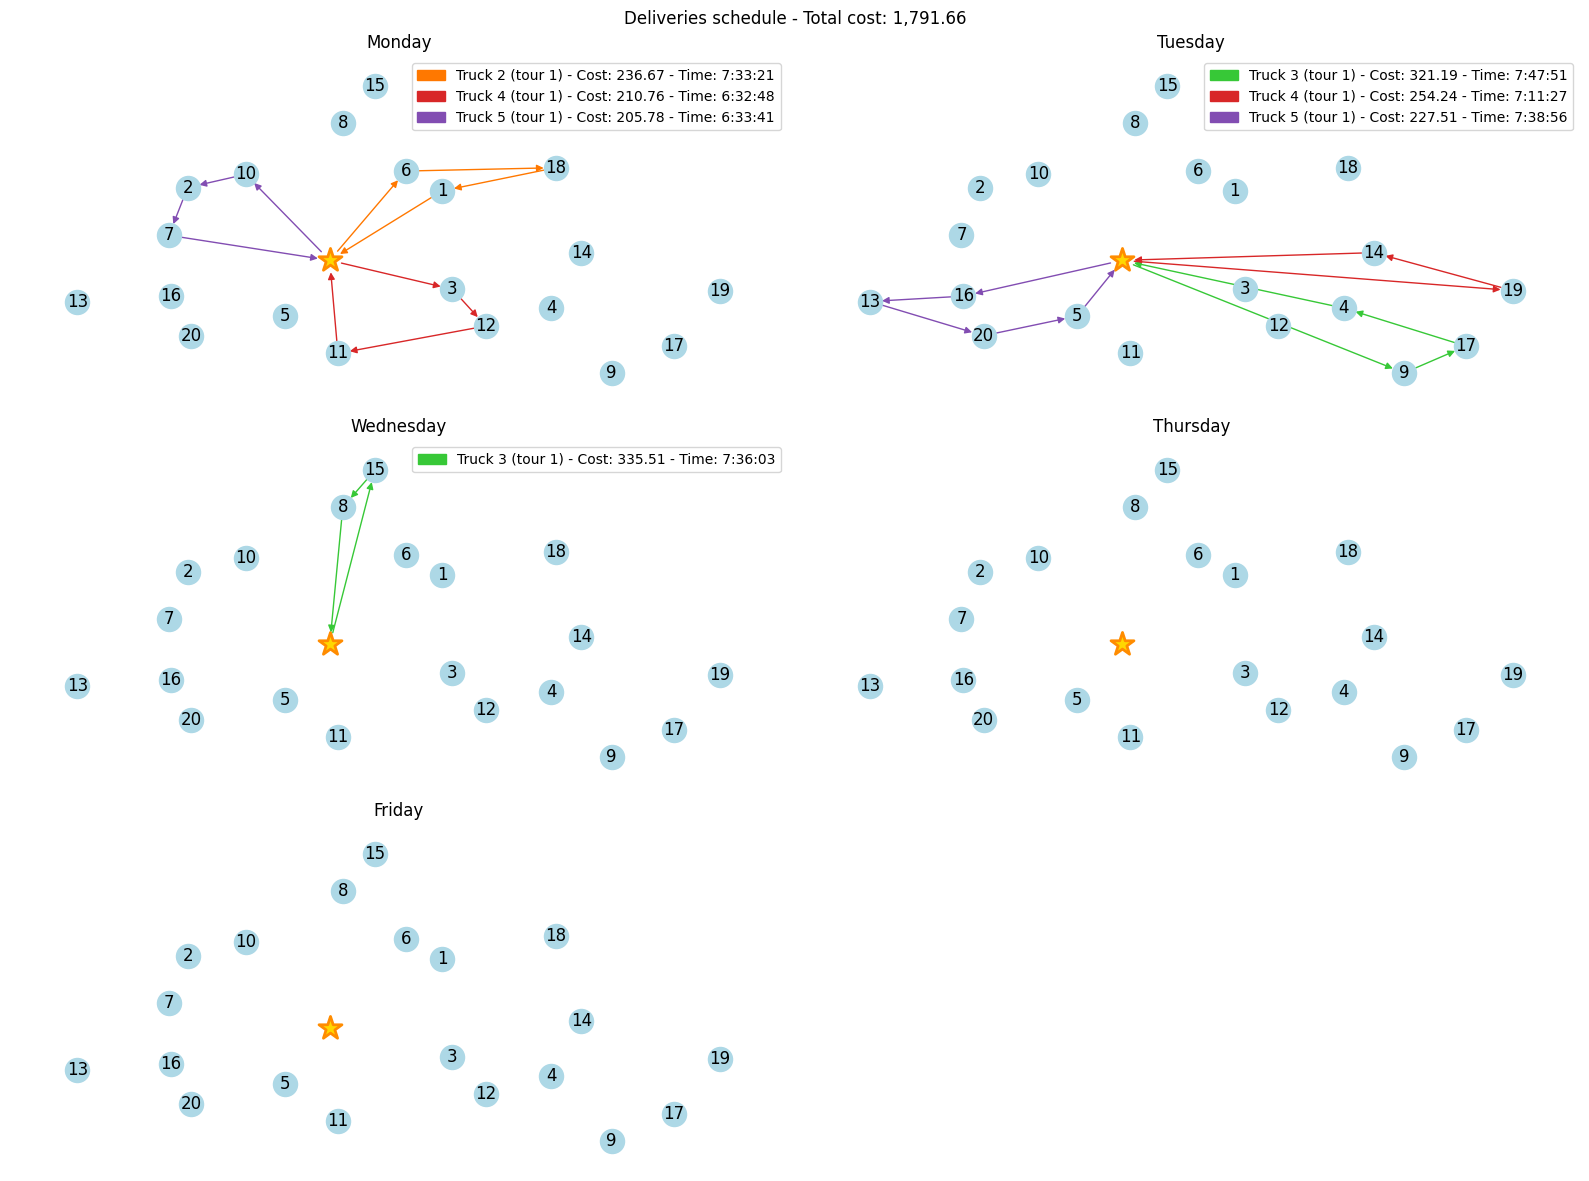

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

# Base colors for each truck
colors = list(mcolors.TABLEAU_COLORS.values())

# Variants for each truck's tour
n_tours = 2 # Maximum amount of tours per day per truck
color_variants = {truck: get_color_variants(colors[truck], n_tours) for truck in trucks.index}

# nodes locations
pos = nx.get_node_attributes(G, "coord")

# Total cost
total_cost = 0

for g, day_name, ax in zip(SG, day_map.keys(), axes.flatten()):
    
    # Set the title
    ax.set_title(day_name)

    # Draw the depot
    ax.scatter(
        *G.nodes[0]["coord"],
        marker="*",
        s=300,
        color="gold",
        edgecolors="darkorange",
        linewidths=2,
        label="Depot (node 0)"
    )
    
    # Draw the orders locations
    orders_graph = deepcopy(G)
    orders_graph.remove_node(0)
    nx.draw_networkx(orders_graph, 
                     pos,
                     node_color="lightblue",
                     width=0.0, # Exclude edges
                     ax=ax)

    # Remove subplots axis from the final display
    ax.axis("off")

    # If there are no edges for this day skip
    if nx.is_empty(g):
        continue

    # List of legend handles
    legend_handles = []
    
    # List the trucks set for this day
    trucks_list = set(nx.get_edge_attributes(g, "truck").values())

    # Create the tours for this day
    tours_graphs = create_tour_graphs(g)

    # Iterate over the trucks
    for t in trucks_list:
        
        # First tour by the truck
        tour_id = 1
        
        for tour in tours_graphs:

            # Check if the tour belongs to the truck
            if list(set(nx.get_edge_attributes(tour, "truck").values()))[0] == t:

                # Select the color for the tour
                edge_color = color_variants[t][tour_id - 1]
    
                # Plot the tour (arcs) with arrows
                nx.draw_networkx_edges(tour, 
                                       pos,
                                       arrows=True, 
                                       edge_color=edge_color, 
                                       ax=ax)
    
                # Legend data
                tour_cost = round(sum(tour[u][v]["cost"] for (u, v) in tour.edges), 2)
                total_cost += tour_cost # Update total cost
                tour_time_seconds = round(3600 * sum(tour[u][v]["total_time"] for (u, v) in tour.edges))
                tour_time = timedelta(seconds=tour_time_seconds)
                
                # Lengend handle
                handle = mpatches.Patch(
                    color=edge_color,
                    label=f"Truck {t + 1} (tour {tour_id}) - Cost: {tour_cost} - Time: {tour_time}"
                )
                legend_handles.append(handle)
                
                # Update the tour count
                tour_id += 1

    # Add the handlers to the subplot
    ax.legend(handles=legend_handles)

# Removing the 6th plot
axes.flatten()[-1].axis("off")

# Add suptitle
fig.suptitle(f"Deliveries schedule - Total cost: {total_cost:,.2f}")

fig.tight_layout()
plt.show()